In [1]:
# Загрузка библиотек необходимых для отрисовки графиков
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint
%matplotlib inline  
import json

In [2]:
# функция расчета плотности воды в зависимости от давления и температуры
def rho_w_kgm3(P_Mpa, T_K, yw):
    return yw /(1+(T_K-273)/10000*(0.269*(T_K-273)**(0.637)-0.8))
    
# Расчет вязкости воды в зависимости от температуры и давления
def visc_w_cP(P_Mpa, T_K):
    A = 109.574
    B = 1.1217
    muw = A * (1.8 * T_K - 460) ** (-B) * (0.9994 + 0.0058 * P_Mpa + 0.6534 * (10) ** (0 - 4) * P_Mpa * P_Mpa)
    return muw

# Расчет числа Рейнольдса 
def Re(q_m3day, d_m, mu_mPas, rho_kgm3):
    # q_m3day - дебит жидкости, м3/сут
    # rho_kgm3 - плотность воды или жидкости, по умолчанию 1000 кг/м3, чистая вода
    # mu_mPas  - вязкость жидкости по умолчанию 0.2 мПас
    # d_m      - диаметр трубы, м
    v_ms = q_m3day/ 86400 / 3.1415 * 4 / d_m ** 2
    return rho_kgm3 * v_ms * d_m / mu_mPas * 1000

def friction_Jain(q_m3day, d_m, mu_mPas, rho_kgm3, roughness):
    Re_val = Re(q_m3day, d_m, mu_mPas, rho_kgm3)
    if Re_val < 3000:
        return 64/Re_val
    else:
        return 1/(1.14-2 * np.log10(roughness/d_m + 21.25 / (Re_val ** 0.9)))**2

# функция расчета градиента давления в нагнетательной скважин
def pressure_gradient_MPam(q_m3day, P_Mpa, T_C, d_m, yw, cos_alpha, roughness):
    # q_m3day - дебит жидкости, м3/сут
    # P_Mpa - давление, МПа
    # T_C - температура, С
    # d_m - диаметр 
    # Ws - соленость 
    # cos_alpha - косинус угол отклонения от вертикали 
    # roughness_m - шероховатость
    rho_kgm3 = rho_w_kgm3(P_Mpa, T_C + 273, yw)
    mu_cP = visc_w_cP(P_Mpa, T_C + 273)
    f = friction_Jain(q_m3day, d_m, mu_cP, rho_kgm3, roughness)
    g = 9.81
    q_m3sec = q_m3day /86400
    return (rho_kgm3 * g * cos_alpha - 0.815 * f * rho_kgm3 /( d_m ** 5) * (q_m3sec )**2) / 1000000

# ИСХОДНЫЕ ДАННЫЕ

In [3]:
input_parametrs = '{"gamma_w": 1.08, "h":770, "d_in":92, "q_liq":253, "eps":2.5E-5, "p_wh": 15.2, "MD": [0, 385, 770], "TVD": [0, 339, 494], "T0": 25.4}'
parametrs = json.loads(input_parametrs)

# Исходные данные для проведения расчета

γw = parametrs['gamma_w']         # удельная плотность воды
Q = parametrs['q_liq']            # дебит скважин м3/сут
Pwh = parametrs['p_wh'] / 10          # буферное давление, бар
Twh = parametrs['T0']             # температура на устье скважины, С
roughness_m = parametrs['eps']    # шероховатость
H = parametrs['h']                # измеренная глубина забоя скважины
dtub_m = parametrs['d_in'] /1000        # диаметр НКТ по которой ведется закачка

# траектория скважины, задается как массив измеренных глубин и значений отклонения от вертикали
Hmes_m = np.array(parametrs['MD'])      
Hvert_m = np.array(parametrs['TVD'])

# Построение графика конструкции скважины

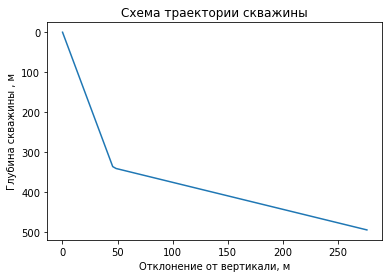

In [4]:
# Подготовка данных по конструкции скважины
# удлинение от измеренной длины - для отрисовки графика
Uld_m = interp1d(Hmes_m, Hmes_m - Hvert_m, kind='linear')
# вертикальная глубина от измеренной
Hv_m = interp1d(Hmes_m, Hvert_m, kind='linear', bounds_error=False)

# готовим данные для отрисовки графика
h_ = np.linspace(1, H, num=100, endpoint=True)
plt.plot(Uld_m(h_), Hv_m(h_), '-')
plt.xlabel("Отклонение от вертикали, м")
plt.ylabel("Глубина скважины , м")
plt.title("Схема траектории скважины")
ax = plt.gca()
ax.invert_yaxis()

# построим массив косинусов углов отклонения от вертикали
Cos_Ang = np.diff(Hvert_m)/np.diff(Hmes_m)
Cos_Ang_red = np.insert(Cos_Ang, 0, 1)

# Интерполируем косинусы углов отклонения по длине и задаем функцию, чтоб данные переходили в нужный формат
Cos_Ang_interp = interp1d(Hmes_m, Cos_Ang_red, bounds_error=False, fill_value='extrapolate')
def Cos_Ang_fl(h, Cos = Cos_Ang_red):
    return Cos_Ang_interp(h)[()]

# Определение температурного градиента

In [5]:
TempGrad = 50 / H

# Решение уравнения на распределение давления и температуры в стволе скважины. Решается система двух уравнений вида

$$ \frac{dP}{dL} = \frac{1}{10^{-5}} \left [  \rho g  \cos \alpha  - 0.815 \frac{f \rho}{d^5} q ^ 2  \right ]  $$

$$ \frac{dT}{dL} = geograd $$

In [6]:
def dPTdL(PT, h):
    dPdL = pressure_gradient_MPam(Q, PT[0], PT[1], dtub_m , γw*1000, Cos_Ang_fl(h), roughness_m)
    dTdL = TempGrad * Cos_Ang_fl(h)
    return [dPdL, dTdL]

# задаем граничные условия
PTwh = [Pwh,Twh]
# определяем диапазон и интервалы интегрирования
hs = np.linspace(0, H, 100)
# решаем систему уравнений численно
PTs = odeint(dPTdL, PTwh, hs)
# созраняем результаты расчета
P = PTs[:,0]
T = PTs[:,1]

# Построение графика распределения давления и температуры по стволу скважины

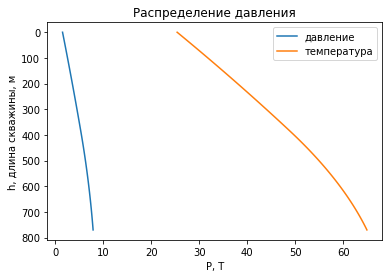

In [7]:
plt.plot(P,hs, label ="давление")
plt.plot(T,hs, label = "температура")
plt.xlabel("P, Т")
plt.ylabel("h, длина скважины, м")
ax = plt.gca()
ax.invert_yaxis()
plt.legend()
plt.title("Распределение давления");

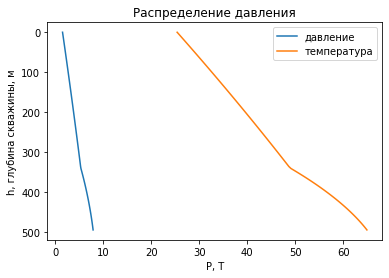

In [8]:
plt.plot(P,Hv_m(hs), label ="давление")
plt.plot(T,Hv_m(hs), label = "температура")
plt.xlabel("P, Т")
plt.ylabel("h, глубина скважины, м")
ax = plt.gca()
ax.invert_yaxis()
plt.legend()
plt.title("Распределение давления");

# Построение графика зависимости забойного давления от дебита 

In [9]:
Q_w = np.linspace(10, 500, 10)
def dPTdL_1(PT, h, q):
    dPdL = round(pressure_gradient_MPam(q, PT[0], PT[1], dtub_m , γw*1000, Cos_Ang_fl(h), roughness_m), 5)
    dTdL = round(TempGrad * Cos_Ang_fl(h), 5)
    return [dPdL, dTdL]

P_z = ([])
for q_w in Q_w:
    PTs = odeint(dPTdL_1, PTwh, hs, (q_w,))
    P = PTs[:,0]
    P = P[len(P)-1]
    P_z = np.append(P_z, P)

Text(0.5, 1.0, 'Зависимость забойного давления от дебита')

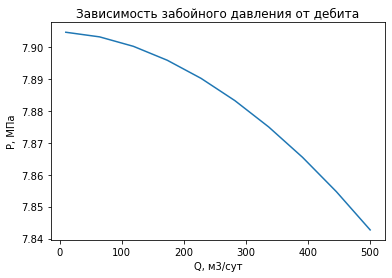

In [10]:
plt.plot(Q_w, P_z)
plt.xlabel("Q, м3/сут")
plt.ylabel("P, МПа")
plt.title('Зависимость забойного давления от дебита')

# Построение графика зависимости забойного давления от устьевой температуры

In [11]:
def dPTdL_2(PT, h):
    dPdL = round(pressure_gradient_MPam(Q, PT[0], PT[1], dtub_m , γw*1000, Cos_Ang_fl(h), roughness_m), 5)
    dTdL = round(TempGrad * Cos_Ang_fl(h), 5)
    return [dPdL, dTdL]

P_z_2 = ([])
T_w = np.linspace(10, 50, 10)
for t in T_w:
    PTwh_var = [Pwh, t]
    PTs_2 = odeint(dPTdL_2, PTwh_var, hs)
    P_2 = np.amax(PTs_2[:,0], 0)
    P_z_2 = np.append(P_z_2, P_2)

Text(0.5, 1.0, 'Зависимость забойного давления от температуры')

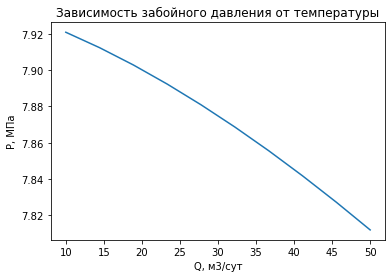

In [12]:
plt.plot(T_w, P_z_2)
plt.xlabel("Q, м3/сут")
plt.ylabel("P, МПа")
plt.title('Зависимость забойного давления от температуры')

In [13]:
result ={"ex1":{"h": hs.tolist(), "p": P.tolist()}, "ex2":{"q_liq": Q_w.tolist(), "p_wf": P_z.tolist()}, "ex3":{"t": T_w.tolist(), "p_wf": P_z_2.tolist()}}
answer = json.dumps(result)
with open('results.json', 'w', encoding='utf-8') as f:
    f.write(answer)